# Deep learning 実演

## 目的
* 実際にDeep learning(AI)の開発を見てもらいAIがどんなものかを(少しでいいので)知ってもらう

# 題材：手書き数字認識
![AI IO](images/IO.png "AI IO")

# Deep learning 開発の流れ
* 環境構築
* データセットの用意
* ネットワーク構築
* 学習
* 評価
* アプリケーション作成


# スライドの見方

In [ ]:
a = 1
b = 2
print('a + b = ', a + b)

# 環境構築
## ハードウェア
### クラウド
* Colaboratory (無料)
* AWS, GCP (基本的に有料)

### 自前
* ノートパソコン
* デスクトップパソコン
  * GPU

## ソフトウェア
* C++, Caffe2
* Python, pytorch
* __Python, Keras__

# データセットの用意
* ~~自分で作成する~~
* 公開されているデータセットを用いる

## MNIST
* 手書き数字データセット
* Modified National Institute of Standards and Technology database
* 学習用：6万枚、　テスト用：1万枚
![mnist examples](images/MnistExamples.png "mnist examples")
* 新しいモデルのテスト等によく使われる

# 公開データセットのダウンロード

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import keras
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(r'学習データ数：{}、テストデータ数：{}'.format(x_train.shape[0], x_test.shape[0]))

Using TensorFlow backend.


学習データ数：60000、テストデータ数：10000


## データの確認

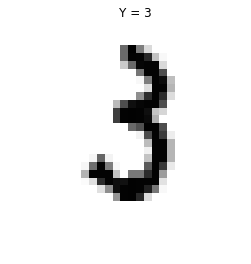

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

def show_image(i):
    plt.imshow(255-x_train[i,:,:], cmap='gray')
    plt.axis('off'), plt.title('Y = {}'.format(y_train[i]))

show_image(random.randint(0, len(x_train)))

# ネットワーク構築

In [57]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


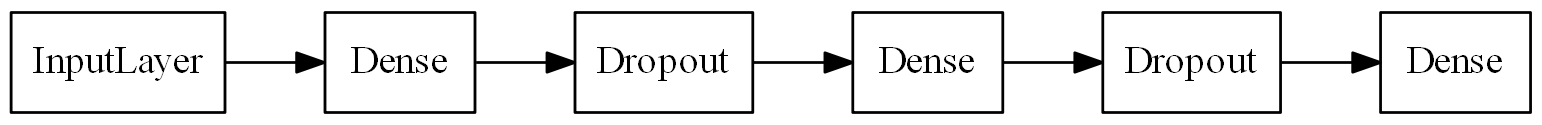

In [58]:
import IPython.display
from keras.utils.vis_utils import plot_model
net_arch = plot_model(model, to_file='images/model.png', show_layer_names=False, rankdir='LR', dpi=200)
IPython.display.display(net_arch)

# テスト (学習前)

In [59]:
# 準備
def test_image(test_input, true_output = None):
    plt.figure(figsize=(10, 6))
    p = model.predict(test_input.flatten()[None,:]/255)[0]
    plt.subplot(1,2,1)
    plt.title('Input (Y = {})'.format(true_output if true_output is not None else '?'))
    plt.imshow(255-test_input, cmap='gray'), plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('Output distribution')
    plt.xticks(range(10),[str(i) for i in range(10)])
    plt.ylim(0,1)
    plt.bar(range(10), p)

def test_model(i):
    test_image(x_test[i], y_test[i])

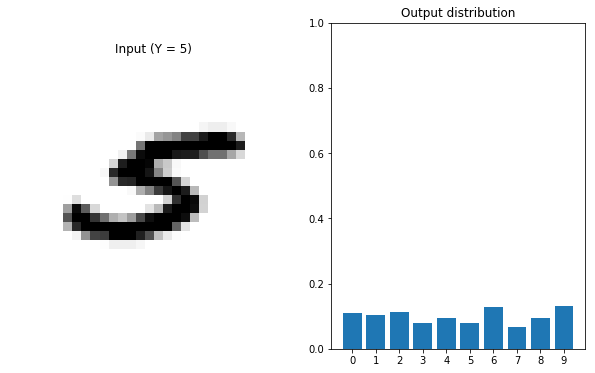

In [60]:
test_model(random.randint(0, len(x_test)))

# 学習
学習用データ6万枚を使用

## 誤差逆伝播
![training](images/training.png "training")

In [61]:
history = model.fit(x_train.reshape(x_train.shape[0],-1)/255, #入力データ
                    y_train, #入力データに対する正解
                    batch_size=32,
                    epochs=1,
                    verbose=1)

Epoch 1/1
60000/60000 [==============================] - 5s 87us/step - loss: 0.2162 - acc: 0.9342


# テスト (学習後)

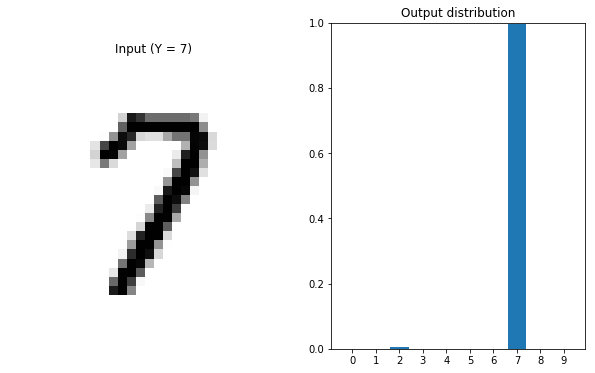

In [62]:
test_model(random.randint(0, len(x_test)))

# 評価
評価用データ1万枚を使用

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
predictions = model.predict(x_test.reshape(x_test.shape[0],-1)/255)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_test, y_pred)
print('正解率 = {} / {} = {}'.format(cm.trace(), cm.sum(), cm.trace() / cm.sum()))

# 混同行列 (Confusion Matrix)

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.set(context='notebook',style="whitegrid",font='serif')
sns.heatmap(cm, annot=True, fmt="d",cmap='Blues', square=True)
plt.xlabel('Prediction'), plt.ylabel('Truth')

# 失敗例

In [ ]:
failures = np.where(y_pred != y_test)[0]
test_model(failures[random.randint(0, len(failures))])

# アプリケーション作成
作成したAIを活用する

## 準備

In [ ]:
from IPython.core.display import HTML
# from https://blog.sky-net.pw/article/70
html_src = '''
<canvas id="canvas" height="280px" width="280px" style="border: 1px solid;"></canvas>
<p>
    <label><input type="checkbox" id="auto_update" value="1" checked="checked">Auto</label>
    <button id="clear">Clear</button>
    <button id="submit">Predict</button>
</p>
<img id="prediction"></img>
<script>
    var kernel = IPython.notebook.kernel;

    var config = {
        "linesize": 10,
        "linecolor": "#000000"
    }

    var mouse = {
        "X": null,
        "Y": null,
    }

    var auto_update = document.getElementById("auto_update");
    var clear = document.getElementById("clear");
    var submit = document.getElementById("submit");
    var canvas = document.getElementById("canvas");
    var prediction = document.getElementById("prediction");
    var ctx = canvas.getContext("2d");
    var last_update = (new Date()).getTime()
    var min_interval = 500

    clear.addEventListener("click", function(){
        ctx.clearRect(0, 0, canvas.width, canvas.height);
    });
    var callbacks = {
            iopub: {
            output: (data) => prediction.setAttribute('src',"data:image/png;base64,"+data.content.data['image/png'])
            }
    }
    
    function predict(){
        kernel.execute("predict('" + canvas.toDataURL() + "')", callbacks);
    }
    submit.addEventListener("click", predict);

    canvas.addEventListener("mouseup", drawEnd, false);
    canvas.addEventListener("mouseout", drawEnd, false);
    
    canvas.addEventListener("mousemove", function(e){
        if (e.buttons === 1 || e.witch === 1) {
            var rect = e.target.getBoundingClientRect();
            var X = e.clientX - rect.left;
            var Y = e.clientY - rect.top;
            draw(X, Y);
        };
    });
 
    canvas.addEventListener("mousedown", function(e){
        if (e.button === 0) {
            var rect = e.target.getBoundingClientRect();
            var X = e.clientX - rect.left;
            var Y = e.clientY - rect.top;
            draw(X, Y);
        }
    });

    function draw(X, Y) {
        ctx.beginPath();
        if (mouse.X === null) {
            ctx.moveTo(X, Y);
        } else {
            ctx.moveTo(mouse.X, mouse.Y);
        }
        ctx.lineTo(X, Y);
        
        ctx.lineCap = "round";
        ctx.lineWidth = config.linesize * 2;
        ctx.strokeStyle = config.linecolor;
        ctx.stroke();

        mouse.X = X;
        mouse.Y = Y;
        if (auto_update.checked && (new Date()).getTime() - last_update > min_interval) {
            last_update = (new Date()).getTime();
            predict();
        }
    };
 
    function drawEnd() {
        mouse.X = null;
        mouse.Y = null;
        if (auto_update.checked) {
            predict();        
        }
    }
</script>
'''
import skimage.transform as transform
from io import BytesIO
from PIL import Image

def predict(base64_img):
    img = np.array(Image.open(BytesIO(base64.b64decode(base64_img.split(",")[-1]))))[:,:,3]
    input_img = transform.downscale_local_mean(img, (10,10))
    test_image(input_img)


In [ ]:
HTML(html_src)

# まとめ
* 手書き数字認識を題材としてDeep learning開発の一連の流れを実演

## Deep learning 開発の流れ (再掲)
* 環境構築
* データセットの用意
* ネットワーク構築
* 学習
* 評価
* アプリケーション作成